## AM115 Group Project - First Draft

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from IPython.display import Image
from math import exp

## SIR model with mutation and vaccination (SIRS model)

### Equations and DAG

The SIRS model can be expressed as a system of ODEs:

$$
\frac{dS}{dt} = - \frac{a}{N} I S - c S + e R
$$

$$
\frac{dI}{dt} = \frac{a}{N} I S - b I
$$

$$
\frac{dR}{dt} = b I + c S - e R
$$

The parameters are defined as follows:
- $N$: total population
- $a$: infection rate
- $b$: recovery rate
- $c$: vaccination rate
- $e$: mutation rate or waning immunity rate

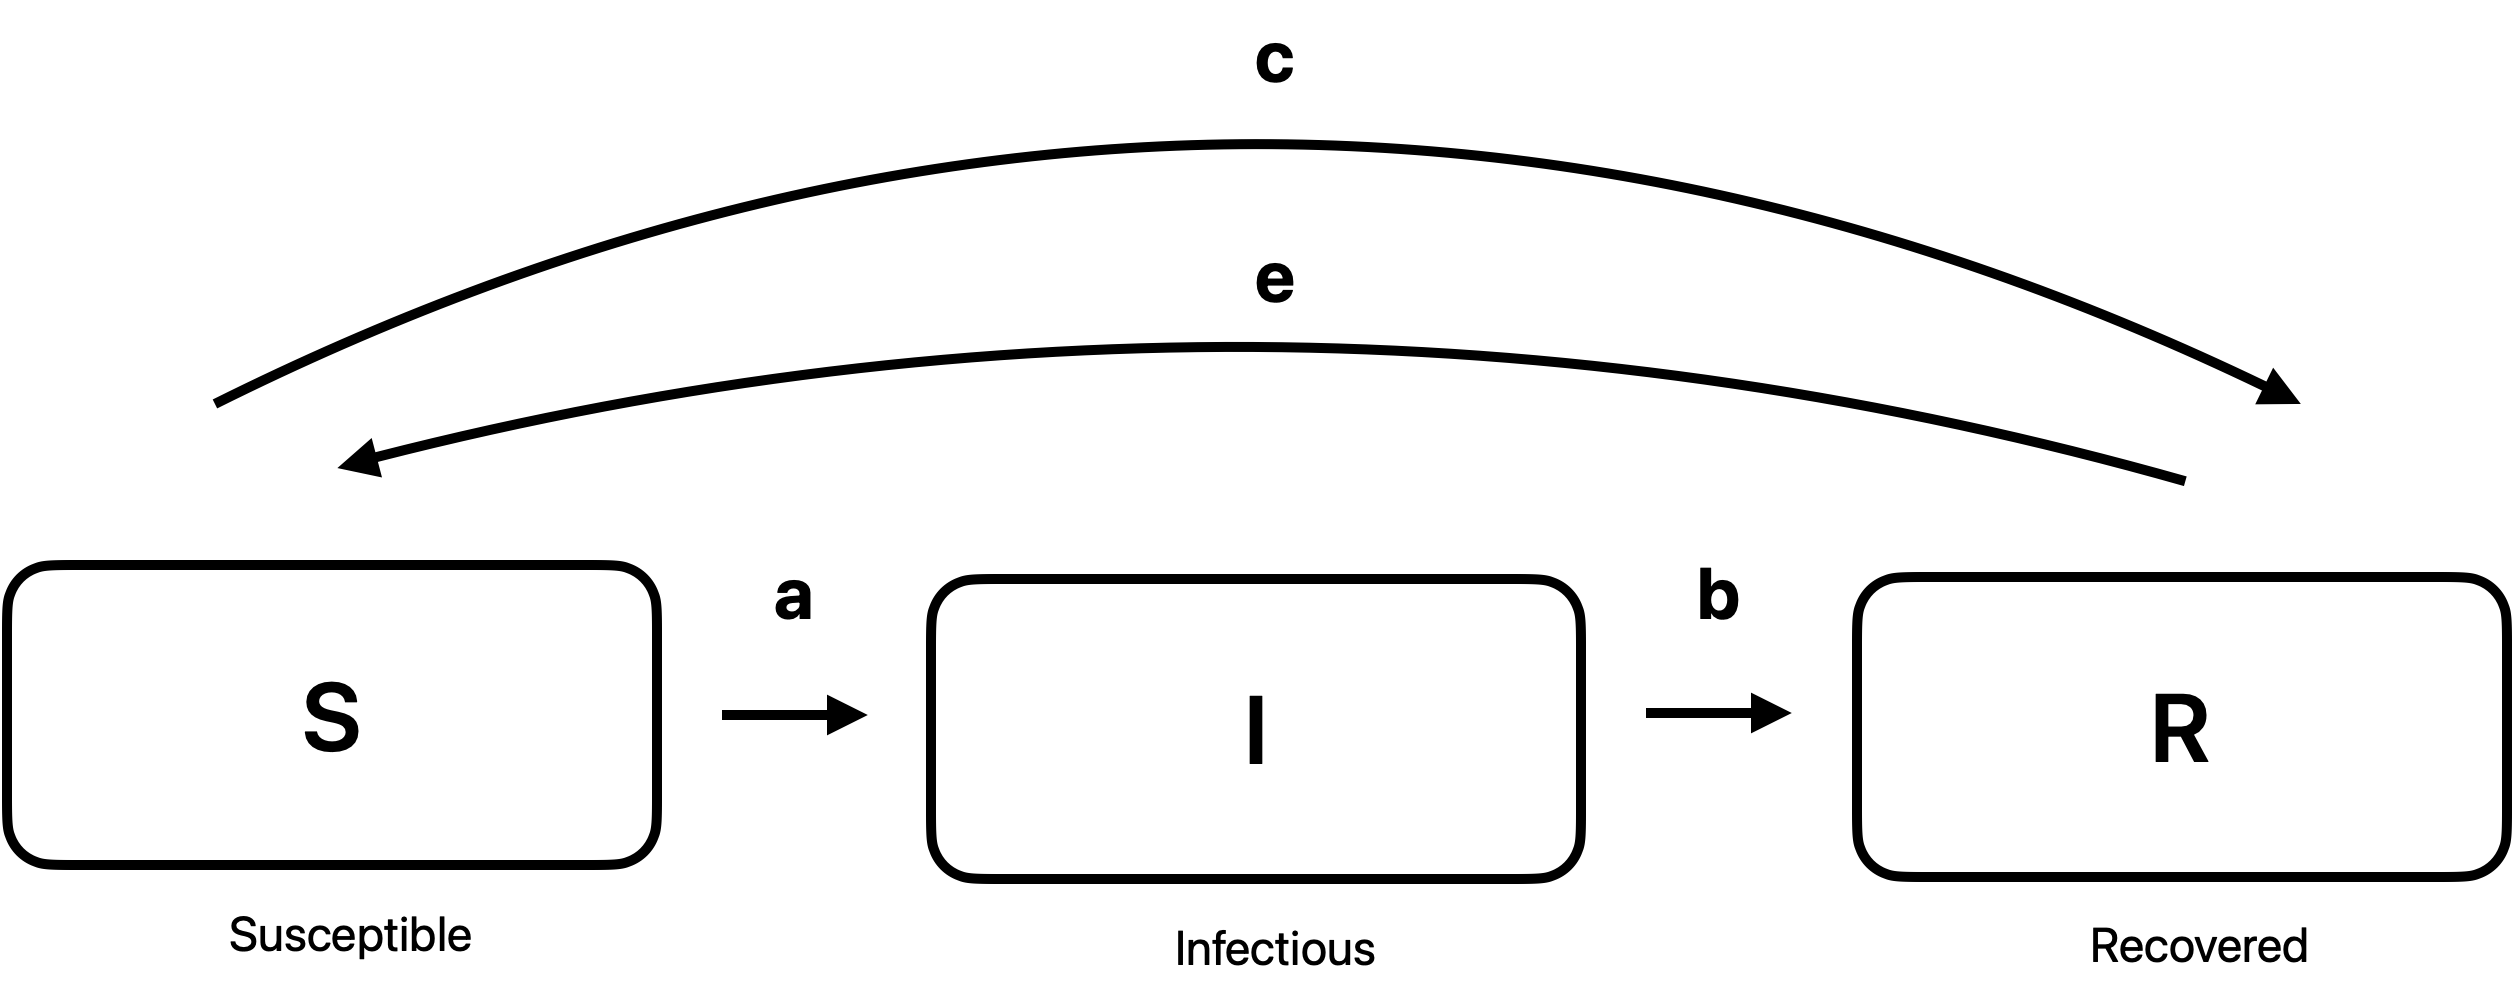

In [3]:
Image("./SIRS_DAG.png", width=500, height=500)

- In the modified DAG, there are now two additional edges from $R$ to $S$ and from $S$ to $I$. The edge from $R$ to $S$ represents the vaccination process, where individuals in the recovered state can be vaccinated and return to the susceptible state. The edge from $S$ to $I$ represents the mutation process, where individuals can become infected again after being vaccinated.
- This DAG is more realistic because it shows us the reason why we need boosters.

In [4]:
def sir(t, X, a, b, c, e, N):

    s = X[0]
    i = X[1]
    r = X[2]
    cumulative = X[3]

    ds = -a * s * i / N - c * s + e * r
    di = a * i * s / N - b * i
    dr = b * i + c * s - e * r

    # Not part of system just to compute cumulative infections
    dcumulative = b * i

    return [ds, di, dr, dcumulative]


# Set parameters
tspan = [0.0, 100]
t_eval = np.arange(0, 100, 0.1)
# R0 is 3 in this case
a = 3 * np.log(2)
b = np.log(2)
# vaccination proportion
c = 0.1
# mutation rate
e = 0.08
# Total population
N = 1000

# S, I, R, Cumulative Infection
X0 = [990, 10, 0, 0]

# Solve ODE with 'Radau' or 'BDF' for stiff problems
sol = solve_ivp(sir, tspan, X0, args=(a, b, c, e, N), method="Radau", t_eval=t_eval)
# Unpack solution
T, X = sol.t, sol.y

### Cumulative Infections

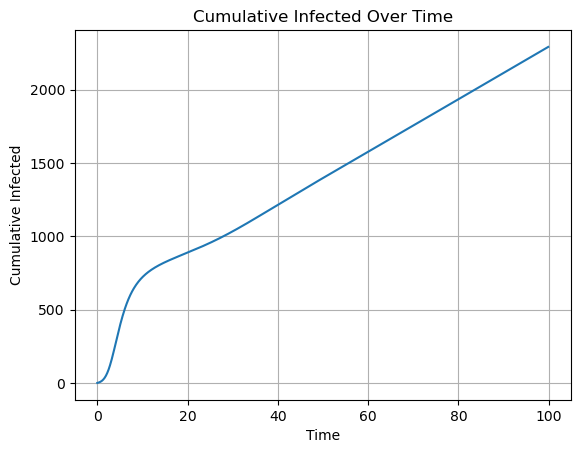

In [5]:
plt.plot(T, X[3], label="Cumulative Infected")
plt.xlabel("Time")
plt.ylabel("Cumulative Infected")
plt.title("Cumulative Infected Over Time")
plt.grid()

- Since the equilibrium is an endemic equilibrium, the cumulative infections will continue to grow over time but at a slower rate than the initial infection rate.

### Model Dynamics

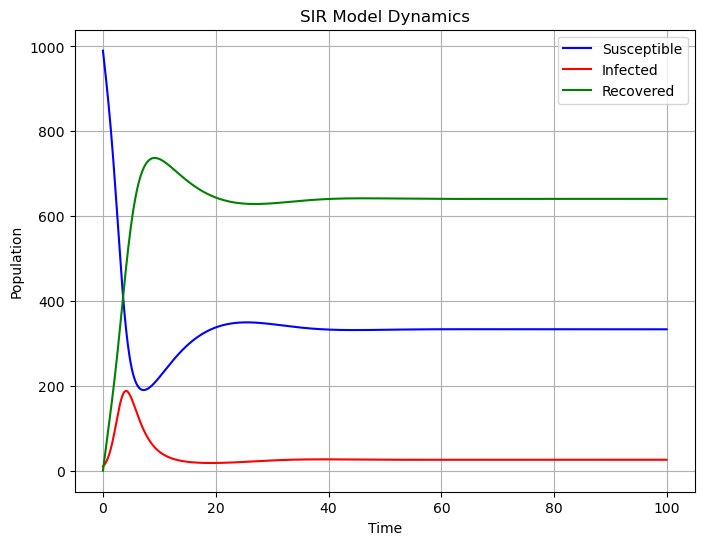

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T, X[0], label="Susceptible", color="blue")
ax.plot(T, X[1], label="Infected", color="red")
ax.plot(T, X[2], label="Recovered", color="green")
ax.set_xlabel("Time")
ax.set_ylabel("Population")
ax.set_title("SIR Model Dynamics")
ax.legend()
ax.grid()
plt.show()

- Endemic equilibrium: the number of infected individuals never reaches zero
- The population is still closed: there is not birth or death
- The point where infected individuals decrease is the same as the SIR model (shown below)

To find when the population of Susceptible when the number of Infected will decrease, we can set $\frac{dI}{dt} = 0$. This gives us:

$$
\frac{a}{N} I S - b I = 0.
$$

$$
\frac{a}{N} S = b. \rightarrow S = \frac{bN}{a}.
$$

From the above, we can say that the proportion of Susceptible individuals at which the number of Infected individuals will start to decrease is when

$$
\frac{S}{N} < \frac{b}{a}.
$$

When the proportion of Susceptible individuals is less than the inverse of the $R_0$ value, the number of Infected individuals will start to decrease.


**Remark**:

To confirm critical point found above is a maximum, we'll take the second derivative:

$$
\frac{d^2I}{dt^2} = I' (\frac{a}{N} S - b) + I \frac{a}{N} S'.
$$

Evaluate it at the critical point:

$$
\frac{d^2I}{dt^2} = I \frac{a}{N} S'
$$

Plug in $S' = - \frac{a}{N} IS$:

$$
\frac{d^2I}{dt^2} = - \frac{a^2}{N}I^2S
$$

We know the second derivative is negative because $a, N, I, S$ are all positive. Therefore, the critical point is a maximum.

### Phase Portrait (I and R)

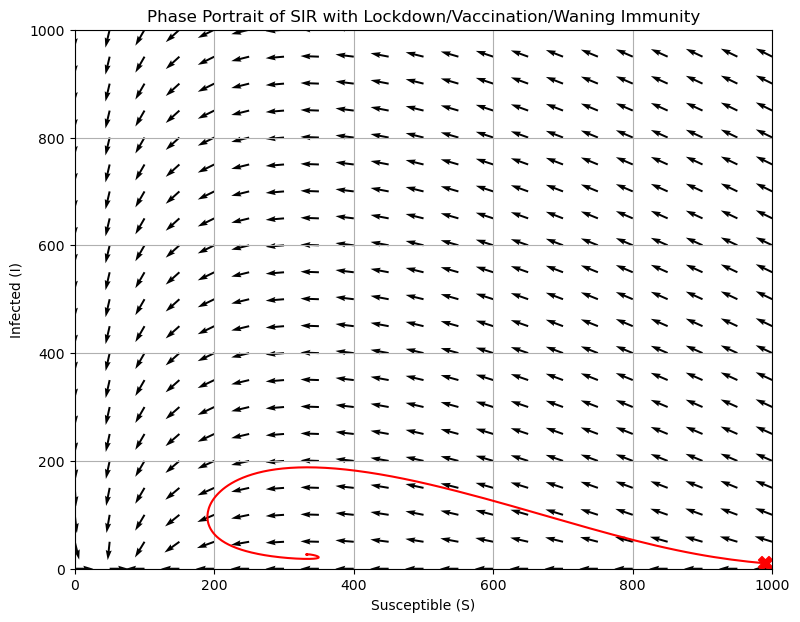

In [7]:
a = 3.0
b = 1.0
c = 0.1
e = 0.01
N = 1000

# Initialize solution arrays
steps = 10
S_vals = np.linspace(0, N, 2 * steps + 1)
I_vals = np.linspace(0, N, 2 * steps + 1)
SS, II = np.meshgrid(S_vals, I_vals)
RR = N - SS - II

u = -a * SS * II / N - c * SS + e * RR
v = a * SS * II / N - b * II

magnitude = np.sqrt(u**2 + v**2)
u_norm = u / (magnitude + 1e-8)
v_norm = v / (magnitude + 1e-8)

# Plot solution
fig, ax = plt.subplots(1, 1, figsize=(9, 7))

# Plot arrows in phase plane
q = ax.quiver(SS, II, u_norm, v_norm, angles="xy")

# Plot trajectory and start point
ax.scatter(X0[0], X0[1], marker="X", color="r", s=100)
ax.plot(X[0, :], X[1, :], color="r", linewidth=1.5)


# Set title, axes labels and legends
ax.set_xlabel("Susceptible (S)")
ax.set_ylabel("Infected (I)")
ax.set_title("Phase Portrait of SIR with Lockdown/Vaccination/Waning Immunity")

ax.set_xlim(0, N)
ax.set_ylim(0, N)

plt.grid()
plt.show()

## SIR model with Mutation, Vaccination and Gradual Lockdown

In [8]:
def sir(t, X, pt, nc, b, c, e, N, lockdown=True):

    s = X[0]
    i = X[1]
    r = X[2]

    # Gradual lockdown
    if lockdown:
        nc = 1 + 5 * np.exp(-0.5 * max(t - 5, 0))

    a = pt * nc

    ds = -a * s * i / N - c * s + e * r
    di = a * i * s / N - b * i
    dr = b * i + c * s - e * r

    return [ds, di, dr]

The system of ODEs:
$$
\frac{dS}{dt} = - \frac{a}{N} I S - c S + e R
$$

$$
\frac{dI}{dt} = \frac{a}{N} I S - b I
$$

$$
\frac{dR}{dt} = b I + c S - e R
$$

Parameters:
$$
a(t) = pt \cdot nc(t)
$$
$$
nc(t) = 1 + 5 e^{-0.5  \max(t - 5, 0)}
$$
- $nc$ is a gradual lockdown

In [9]:
# Set parameters according to the problem specs
tspan = [0.0, 10]
t_eval = np.arange(0, 10, 0.1)
# R0 is 4 in this case
nc = 8
pt = 0.5
b = 1
# vaccination proportion
c = 0.1
# mutation rate
e = 0.01
N = 1000

# S, I, R
X0 = [999, 1, 0]

# Solve ODE with 'Radau' or 'BDF' for stiff problems
sol = solve_ivp(
    lambda t, X: sir(t, X, pt, nc, b, c, e, N, lockdown=False),
    tspan,
    X0,
    t_eval=t_eval,
    method="Radau",
)
# Unpack solution
T, X = sol.t, sol.y

# Solve ODE with 'Radau' or 'BDF' for stiff problems
sol_lock = solve_ivp(
    lambda t, X: sir(t, X, pt, nc, b, c, e, N, lockdown=True),
    tspan,
    X0,
    t_eval=t_eval,
    method="Radau",
)
# Unpack solution
T_lock, X_lock = sol_lock.t, sol_lock.y

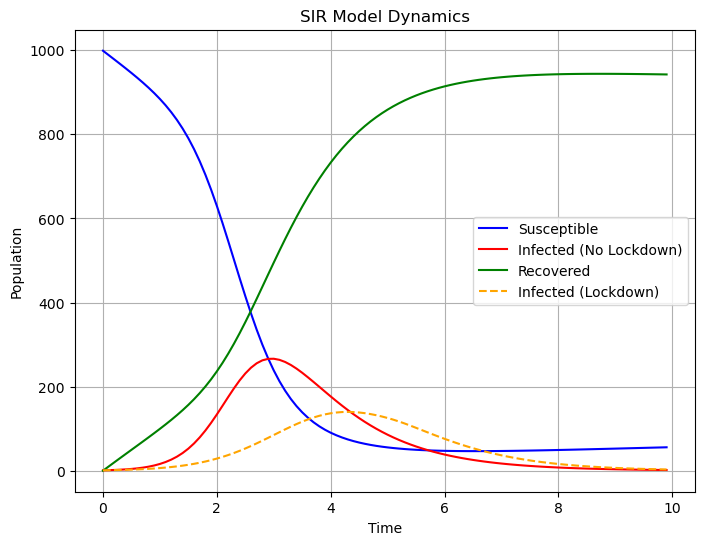

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T, X[0], label="Susceptible", color="blue")
ax.plot(T, X[1], label="Infected (No Lockdown)", color="red")
ax.plot(T, X[2], label="Recovered", color="green")
ax.plot(T, X_lock[1], label="Infected (Lockdown)", color="orange", linestyle="--")
ax.set_xlabel("Time")
ax.set_ylabel("Population")
ax.set_title("SIR Model Dynamics")
ax.legend()
ax.grid()
plt.show()

In [11]:
def nc_func(t, sharpness):
    t0 = max(t - 5, 0)
    drop = 5 * np.exp(sharpness * t0)
    return min(6, 1 + drop)

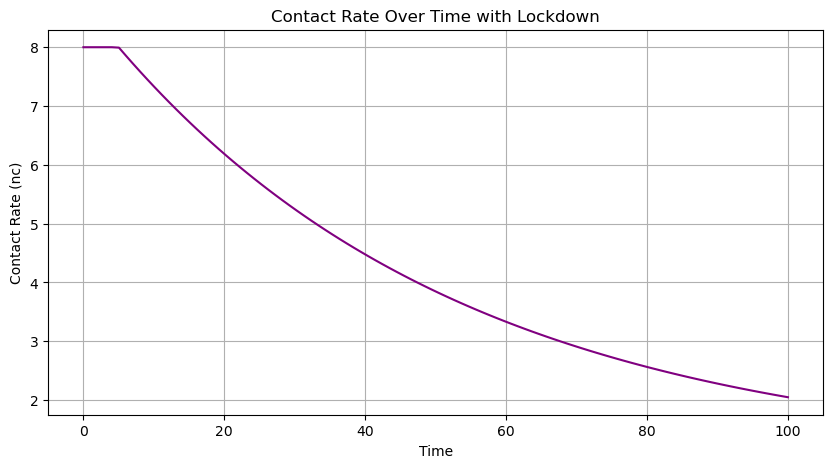

In [70]:
t = np.linspace(0, 100, 100)

sharpness = -0.02
ncs = [nc_func(ti, sharpness) for ti in t]


plt.figure(figsize=(10, 5))
plt.plot(t, ncs, label="Contact Rate (nc)", color="purple")
plt.xlabel("Time")
plt.ylabel("Contact Rate (nc)")
plt.title("Contact Rate Over Time with Lockdown")
plt.grid()
plt.show()

- At $t = 5$, the lockdown starts to take effect, and the number of contacts per infected individual decreases. This is represented by the $nc$ parameter, which gradually decreases from 6 to 1 from $ 5 \leq t \leq 20$.

## SEIRD Model
- states: Susceptible, Infected, Exposed, Dead, Recovered

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from IPython.display import Image
from math import exp

In [14]:
def nc_func(t, sharpness):
    t0 = max(t - 5, 0)
    drop = 5 * np.exp(sharpness * t0)
    return min(6, 1 + drop)

In [15]:
def lockdown_intensity(t, sharpness):
    nc_max = 6
    return (nc_max - nc_func(t, sharpness)) / (nc_max - 1)

In [16]:
def economic_cost(t, alpha, sharpness):
    return alpha * lockdown_intensity(t, sharpness)

In [ ]:
def seird(t, X, pt, nc, b, c, eta, gamma, nu, N, lockdown=False, sharpness=None):
    if lockdown:
        if sharpness is None:
            raise ValueError("If lockdown=True, sharpness must be provided.")
        # Define a time-varying nc_func here. This is a placeholder:
        nc_func = lambda t: nc / (1 + sharpness * t)  # Example dynamic nc
        nc_val = nc_func(t)
    else:
        nc_val = nc

    a = pt * nc_val
    s, e, i, r, d = X
    ds = -a * s * i / N - c * s + gamma * r
    de = a * s * i / N - nu * e
    di = nu * e - b * i - eta * i
    dr = b * i + c * s - gamma * r
    dd = eta * i
    return [ds, de, di, dr, dd]

In [29]:
def simulate_seird(sharpness, alpha, t_span, y0, pt, b, c, eta, gamma, nu, N):
    def rhs(t, X):
        nc = nc_func(t, sharpness)
        a = pt * nc
        s, e, i, r, d = X
        ds = -a * s * i / N - c * s + gamma * r
        de = a * s * i / N - nu * e
        di = nu * e - b * i - eta * i
        dr = b * i + c * s - gamma * r
        dd = eta * i
        return [ds, de, di, dr, dd]

    sol = solve_ivp(rhs, t_span, y0, t_eval=np.linspace(t_span[0], t_span[1], 400))
    return sol

In [30]:
def total_cost(sharpness, alpha, t_span, y0, pt, b, c, eta, gamma, nu, N):
    sol = simulate_seird(sharpness, alpha, t_span, y0, pt, b, c, eta, gamma, nu, N)
    t = sol.t
    deaths = sol.y[4]
    death_cost = deaths[-1]
    econ_cost = np.trapz([economic_cost(ti, alpha, sharpness) for ti in t], t)
    return death_cost + econ_cost

In [31]:
from scipy.optimize import minimize_scalar

# Define parameters
t_span = (0, 60)
N = 1000
y0 = [999, 1, 0, 0, 0]
pt = 0.1
b = 0.1
c = 0.001
eta = 0.01
gamma = 0.001
nu = 0.2
alpha = 1  # weight of economic cost

# Minimize
from scipy.optimize import minimize

res = minimize_scalar(
    total_cost,
    bounds=(-2.0, -0.01),
    method="bounded",
    args=(alpha, t_span, y0, pt, b, c, eta, gamma, nu, N),
)


print(f"Optimal sharpness: {res.x:.4f}")
print(f"Minimum total cost: {res.fun:.2f}")

Optimal sharpness: -0.0661
Minimum total cost: 47.53


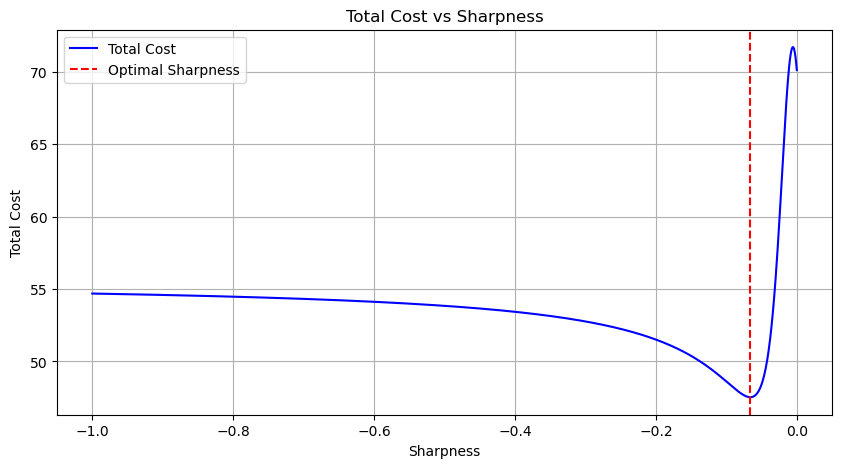

In [32]:
# plot total cost as a function of sharpness
sharpness_values = np.linspace(-1, -0.0001, 1000)
total_costs = [
    total_cost(sharpness, alpha, t_span, y0, pt, b, c, eta, gamma, nu, N)
    for sharpness in sharpness_values
]
plt.figure(figsize=(10, 5))
plt.plot(sharpness_values, total_costs, label="Total Cost", color="blue")
plt.axvline(res.x, color="red", linestyle="--", label="Optimal Sharpness")
plt.xlabel("Sharpness")
plt.ylabel("Total Cost")
plt.title("Total Cost vs Sharpness")
plt.legend()
plt.grid()
plt.show()

- pt: probability of transmission per contact
- nc: number of contacts
- b: recovery rate
- c: preemptive protection rate (e.g. vaccination)
- d_rate: death rate (from I)
- e_rate: immunity waning rate (R → S)
- f: rate E → I (incubation rate)
- N: total population

The system of ODEs:
$$
\frac{dS}{dt} = - \frac{a}{N} I S - c S + \gamma R
$$

$$
\frac{dE}{dt} = \frac{a}{N} I S - \nu E
$$

$$
\frac{dI}{dt} = \nu E - b I - \eta I
$$

$$
\frac{dR}{dt} = b I + c S - \gamma R
$$

$$
\frac{dD}{dt} = \eta I
$$

Parameters:
$$
a(t) = pt \cdot nc(t)
$$
$$
nc(t) = 1 + 5 e^{-0.5  \max(t - 5, 0)}
$$
- $nc$ is a gradual lockdown

In [ ]:
# Set parameters according to the problem specs
tspan = [0.0, 40]
t_eval = np.arange(0, 40, 0.1)
# R0 is 4 in this case
nc = 8
pt = 0.5
b = 1
# vaccination proportion
c = 0.05
N = 1000
eta = 0.05  # death rate from infected
gamma = 0.01  # immunity waning rate
nu = 0.95  # incubation rate


# S, E, I, R, D
X0 = [990, 9, 1, 0, 0]
sharpness = -0.1

# Solve ODE with 'Radau' or 'BDF' for stiff problems
sol = solve_ivp(
    lambda t, X: seird(
        t, X, pt, nc, b, c, eta, gamma, nu, N, lockdown=False, sharpness=sharpness
    ),
    tspan,
    X0,
    t_eval=t_eval,
    method="Radau",
)
# Unpack solution
T, X = sol.t, sol.y

# S, E, I, R, D
X0 = [990, 9, 1, 0, 0]

# Solve ODE with 'Radau' or 'BDF' for stiff problems
sol_lock = solve_ivp(
    lambda t, X: seird(
        t, X, pt, nc, b, c, eta, gamma, nu, N, lockdown=True, sharpness=sharpness
    ),
    tspan,
    X0,
    t_eval=t_eval,
    method="Radau",
)
# Unpack solution
T_lock, X_lock = sol_lock.t, sol_lock.y

In [44]:
from scipy.integrate import simpson

alpha = 1000
lockdown_cost = simpson([economic_cost(t, alpha, sharpness) for t in T_lock], T_lock)

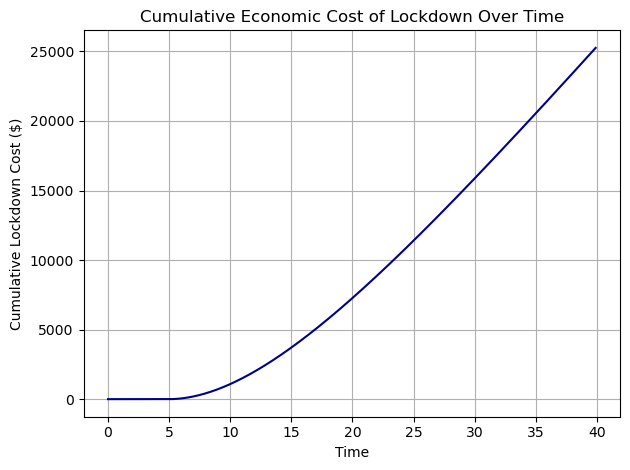

In [45]:
cost_over_time = [economic_cost(t, alpha, sharpness) for t in T_lock]
dt = T_lock[1] - T_lock[0]

# Cumulative cost: integrate cost over time using simple trapezoidal rule
cumulative_cost = np.cumsum(cost_over_time) * dt

plt.plot(T_lock, cumulative_cost, color="darkblue")
plt.xlabel("Time")
plt.ylabel("Cumulative Lockdown Cost ($)")
plt.title("Cumulative Economic Cost of Lockdown Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

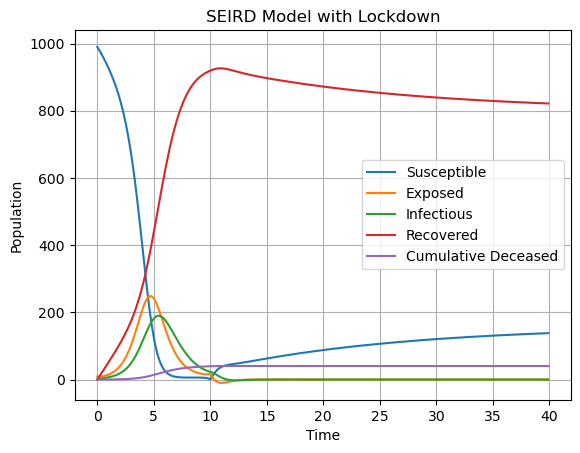

In [46]:
import matplotlib.pyplot as plt

labels = ["Susceptible", "Exposed", "Infectious", "Recovered", "Cumulative Deceased"]
for i in range(5):
    plt.plot(T_lock, X_lock[i], label=labels[i])
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("SEIRD Model with Lockdown")
plt.legend()
plt.grid(True)
plt.show()

In [47]:
np.allclose(np.sum(X_lock, axis=0), N)

True

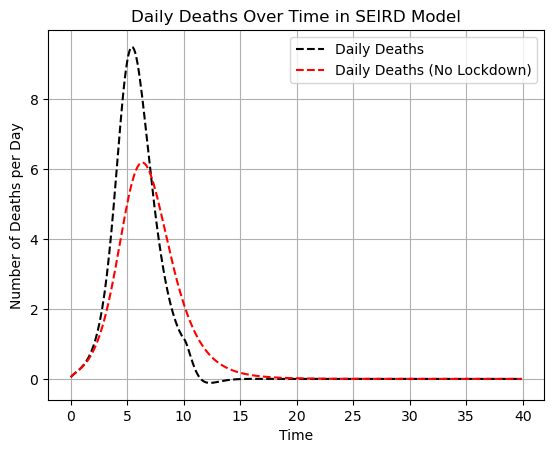

In [48]:
# Compute daily deaths = d_rate * I(t)
daily_deaths = eta * X_lock[2]  # Infectious compartment
daily_deaths_no_lockdown = eta * X[2]  # Infectious compartment without lockdown

# Plot daily deaths over time
plt.plot(T_lock, daily_deaths, label="Daily Deaths", color="black", linestyle="--")
plt.plot(
    T,
    daily_deaths_no_lockdown,
    label="Daily Deaths (No Lockdown)",
    color="red",
    linestyle="--",
)
plt.xlabel("Time")
plt.ylabel("Number of Deaths per Day")
plt.title("Daily Deaths Over Time in SEIRD Model")
plt.grid(True)
plt.legend()
plt.show()

Sensitivity Analysis Ideas
- Sharp lockdown

Sources
1. https://como-dtc-collaboration.github.io/como-models/articles/SEIRD.html
2. https://www.nature.com/articles/s41598-021-97260-0

## Parameters Research
- sensitivity of optimal sharpness for different alpha
- sensitivity of optimal sharpness for different pt

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from IPython.display import Image
from math import exp

In [50]:
def nc_func(t, sharpness):
    t0 = max(t - 5, 0)
    drop = 7 * np.exp(sharpness * t0)
    return min(8, 1 + drop)


def lockdown_intensity(t, sharpness):
    nc_max = 8
    return (nc_max - nc_func(t, sharpness)) / (nc_max - 1)


def economic_cost(t, sharpness):
    return lockdown_intensity(t, sharpness)

In [51]:
def simulate_seird(sharpness, alpha, t_span, y0, pt, b, c, eta, gamma, nu, N):
    def rhs(t, X):
        nc = nc_func(t, sharpness)
        a = pt * nc
        s, e, i, r, d = X
        ds = -a * s * i / N - c * s + gamma * r
        de = a * s * i / N - nu * e
        di = nu * e - b * i - eta * i
        dr = b * i + c * s - gamma * r
        dd = eta * i
        return [ds, de, di, dr, dd]

    sol = solve_ivp(rhs, t_span, y0, t_eval=np.linspace(t_span[0], t_span[1], 400))
    return sol


def total_cost(sharpness, alpha, t_span, y0, pt, b, c, eta, gamma, nu, N):
    sol = simulate_seird(sharpness, alpha, t_span, y0, pt, b, c, eta, gamma, nu, N)
    t = sol.t
    deaths = sol.y[4]
    death_cost = deaths[-1]  # final number of deaths
    econ_cost = np.trapz([economic_cost(ti, sharpness) for ti in t], t)
    return death_cost + alpha * econ_cost

In [62]:
from scipy.optimize import minimize_scalar

# Define parameters
# Fixed Parameters
t_span = (0, 60)
N = 1000
y0 = [999, 1, 0, 0, 0]
c = 0.013
eta = 0.01
gamma = 0.008
nu = 0.22
b = 0.2

pt = 0.1
alpha = 1  # weight of economic cost

- $\alpha = 0.5$ implies \$5M of economic impact is valued equivalently to 1 life lost (since $\alpha$ = 0.5 means the model treats 0.5 units of economic cost = 1 death).
- we use 1 unit of economic cost = 1 death as a baseline for our model.
- Let a life be worth \$10M, then $\alpha = 0.1$ implies \$1M of economic impact is valued equivalently to 1 life lost (since $\alpha$ = 0.1 means the model treats 0.1 units of economic cost = 1 death).

In [63]:
nc

8

In [64]:
print(nc * pt)
a = nc * pt
print(a / b)

0.8
4.0


In [65]:
# Minimize
from scipy.optimize import minimize_scalar

res = minimize_scalar(
    total_cost,
    bounds=(-2.0, -0.01),
    method="bounded",
    args=(alpha, t_span, y0, pt, b, c, eta, gamma, nu, N),
)


print(f"Optimal sharpness: {res.x:.4f}")
print(f"Minimum total cost: {res.fun:.2f}")

Optimal sharpness: -0.0100
Minimum total cost: 29.21


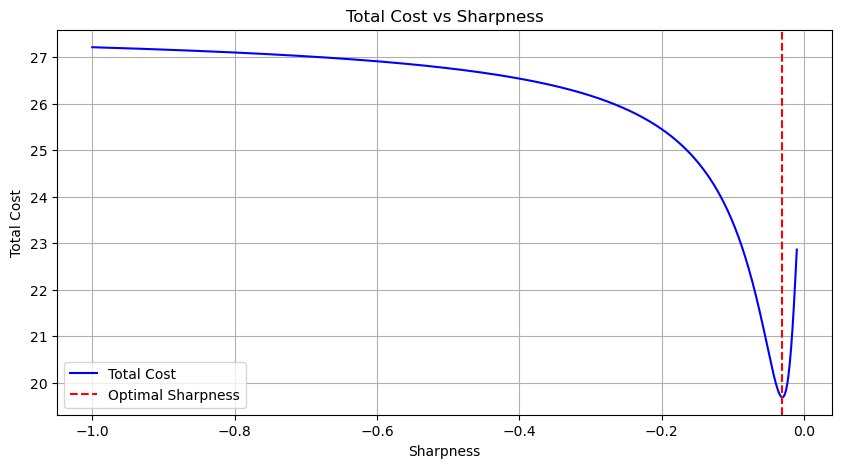

In [56]:
# plot total cost as a function of sharpness
sharpness_values = np.linspace(-1, -0.01, 1000)
total_costs = [
    total_cost(sharpness, alpha, t_span, y0, pt, b, c, eta, gamma, nu, N)
    for sharpness in sharpness_values
]
plt.figure(figsize=(10, 5))
plt.plot(sharpness_values, total_costs, label="Total Cost", color="blue")
plt.axvline(res.x, color="red", linestyle="--", label="Optimal Sharpness")
plt.xlabel("Sharpness")
plt.ylabel("Total Cost")
plt.title("Total Cost vs Sharpness")
plt.legend()
plt.grid()
plt.show()

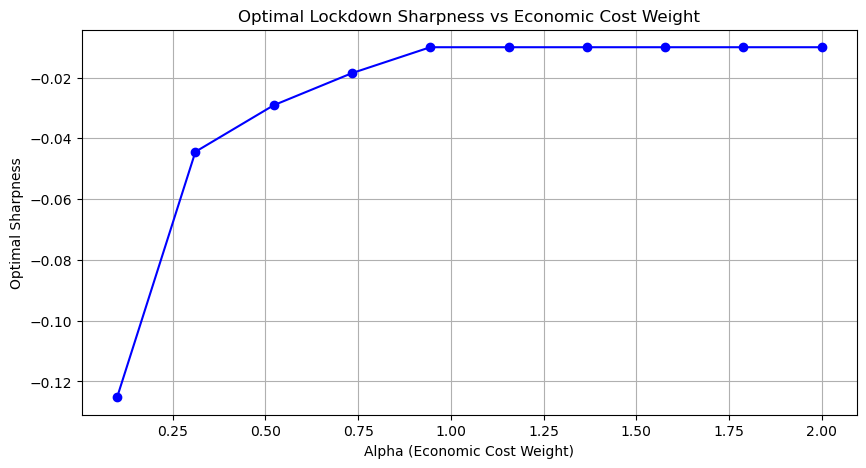

In [68]:
# plot optimal lockdown steepness vs alpha

num_candidates = 10
optimal_sharpness = np.zeros(num_candidates)
candidate_alphas = np.linspace(0.1, 2.0, num_candidates)  # Economic cost weights
for i, alpha in enumerate(candidate_alphas):
    res = minimize_scalar(
        total_cost,
        bounds=(-2.0, -0.01),
        method="bounded",
        args=(alpha, t_span, y0, pt, b, c, eta, gamma, nu, N),
    )
    optimal_sharpness[i] = res.x

plt.figure(figsize=(10, 5))
plt.plot(candidate_alphas, optimal_sharpness, marker="o", color="blue")
plt.xlabel("Alpha (Economic Cost Weight)")
plt.ylabel("Optimal Sharpness")
plt.title("Optimal Lockdown Sharpness vs Economic Cost Weight")
plt.grid()
plt.show()

- an alpha = 1 is valuing 1 human life at \$10M
- an alpha = 2 is valuing 1 human life at \$20M
- as the value of alpha increase the steepness of the lockdown becomes more shallow because the economic cost is more expensive

Text(0.5, 1.0, 'Optimal Lockdown Sharpness vs Vaccination Proportion')

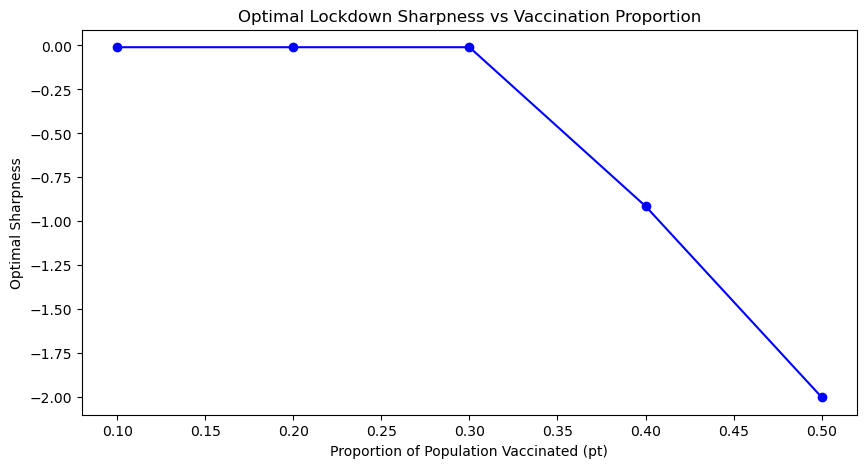

In [ ]:
# sensitivity of optimal sharpness for different pt

pt_values = [0.1, 0.2, 0.3, 0.4, 0.5]
optimal_sharpness_pt = np.zeros(len(pt_values))
for i, pt in enumerate(pt_values):
    res = minimize_scalar(
        total_cost,
        bounds=(-2.0, -0.01),
        method="bounded",
        args=(alpha, t_span, y0, pt, b, c, eta, gamma, nu, N),
    )
    optimal_sharpness_pt[i] = res.x

plt.figure(figsize=(10, 5))
plt.plot(pt_values, optimal_sharpness_pt, marker="o", color="blue")
plt.xlabel("Proportion of Population Vaccinated (pt)")
plt.ylabel("Optimal Sharpness")
plt.title("Optimal Lockdown Sharpness vs Vaccination Proportion")
plt.show()